#### DICOM imgages
(C) MK & ASL & AL

Created: 2019.11.11

Modified: 2019.11.18

In [1]:
import os
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt

###### Additional functions

In [2]:
def list_2_txt(flist, savePath):
    with open(savePath, 'w') as f:
        for item in flist:
            f.write("%s\n" % item)
    print('list saved to: %s' % savePath)

In [3]:
def info(img, name='image'):
    print(' {}: min={:.2f}, aver={:.2f},  max={:.2f}, \
shape={},dtype={}'.format(name, img.min(), img.mean(), img.max(), img.shape, img.dtype))

In [4]:
def text_wrap(fname = ''):
    """
    C: 2019.06.18
    M: 2019.06.22
    """
    if not len(fname):
        fname=os.path.basename(__file__)
    print()
    p = len(fname) + 8
    print(p * '#')
    print("### %s ###" % fname)
    print(p * '#')

In [5]:
def pthInfo():
    print("Current folder is:\n\t%s"  % os.getcwd())

#### Main script 

In [6]:
# Folder with all Nifit images
adniPth = os.path.join('/','media','mk','p1ext4','no19','adni')
adniMainPth = os.path.join(adniPth, 'ADNI_from_Alexander', 'DownloadedNIfTI')
folder = os.path.join(adniMainPth, 'ADNI')

dcm2npyPth = os.path.join(adniMainPth, 'DCM2NPY')
statslPth = os.path.join(adniMainPth, 'STATSL')
statim3dPth = os.path.join(adniMainPth, 'STATIM3D')

# A global variable
PRINT = False

os.chdir(folder)
pthInfo()

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/ADNI


##### Number of all subject folders in my database (ADNI) - 1488 objects

In [7]:
! ls | wc -l

1488


##### Number of all *.dcm in subfolders

In [8]:
!find . -type f -iname "*.dcm" | wc -l

305613


##### Walk through folder tree structure

"""
Folder tree structure in ADNI data folder


    ---> ADNI
        ---> SUBJECT (002_S_0295)  
            ---> MT1__N3m
            ---> MP-RAGE
            ---> MPRAGE                
                    ---> 2009-04-30_10_58_19.0
                                ---> S666999
                                        ---> DCM files (x 170)
    
"""

In [9]:
def convertDICOM2NPY(savePth=''):
    """
    1. Reads all *.dcm files in a current folder, stores them in a 3D array and save a matrix to one *.npy file.
    """
    
    # find all *dcm files    
    files = os.listdir('.')
    files = [f for f in files if f.endswith('.dcm')]
    files.sort()
   
    # load all DICOM files
    dcms = []
    for f in files:
        dcms.append(dicom.dcmread(f))
    if PRINT:
        print("\nfile count in dcms: {}".format(len(dcms)))
    
    # skip files with no SliceLocation (eg scout views)
    slices = []
    skipcount = 0
    for d in dcms:
        if hasattr(d, 'SliceLocation'):
            slices.append(d)
        else:
            skipcount = skipcount + 1
    if PRINT:
        print("skipped files without 'SliceLocation': {}".format(skipcount))
    
    # ensure they are in the correct order - sort them
    slices = sorted(slices, key=lambda s: s.SliceLocation)
    
    # create 3D array
    img_shape = list(slices[0].pixel_array.shape)
    img_shape.append(len(slices))
    pixelType = slices[0].pixel_array.dtype
    img3d = np.zeros(img_shape, dtype=pixelType)
    
    # fill 3D array with the images from the files
    for i, s in enumerate(slices):
        img2d = s.pixel_array
        img3d[:, :, i] = img2d
    
    # if saveName is provided images are saved to *.npy file in the DCM2NII folder
    if len(savePth):        
        np.save(savePth, img3d)
        if PRINT:
            print('saved to: %s' % savePth)
    
    return img3d

In [10]:
# Main part of the algorithm
# Walk through a folder tree in ADNI directory

os.chdir(folder)
pthInfo()
# pth to current dir
curDir = os.getcwd()

# find all subjects
subDirs = os.listdir('.')
subDirs = [d for d in subDirs if os.path.isdir(d)]
subDirs.sort()
subCnt = 0

nameToFind = 'rage'

# go into subject dir 
for sub in subDirs[:30]: 
    subCnt += 1
    os.chdir(sub)
    examsDir = os.listdir('.')
    examsDir = [d for d in examsDir if os.path.isdir(d)]
    examsDir = [d for d in examsDir if nameToFind in d.lower()]
    
    for exam in examsDir:
        os.chdir(exam)
        dateDirs = os.listdir('.')
        for date in dateDirs:
            os.chdir(date)
            sDirs = os.listdir('.')
            for s in sDirs:
                os.chdir(s)
                dcmFiles = os.listdir('.')
                dcmFiles = [f for f in dcmFiles if f.lower().endswith('.dcm')]
                
                ##########################################
                # here should be a main part of the algorithm

                # convertion from DICOM to Nifti
                saveName = "{}-{}.npy".format(sub, s)
                if PRINT:
                    text_wrap(saveName)
                savePth = os.path.join(dcm2npyPth, saveName) # DCM2NPY folder
                im3dx = convertDICOM2NPY(savePth)  
                
                ##########################################             
                
                # go up from s
                os.chdir('../')
            # go up from date
            os.chdir('../')    
        # go up form exam
        os.chdir('../')    
    # go up from sub
    os.chdir('../')

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/ADNI


---

In [11]:
def getStatistics(im3d, savePthSL='', savePthIm3d=''):
    """
    Get min, max, mean, std values for each 2D DCIOM slice and for 3D matrix (that consists of all 2D slices) 
    """
    # statistisc for each slide separately
    sz = im3d.shape[-1] # slice number
    statsSL = np.zeros((sz, 4), dtype=np.float32)
    for i in range(sz):
        statsSL[i] = im3d[i].min(), im3d[i].max(), im3d[i].mean(), im3d[i].std()

    # statistics for a 3D image
    statsIm3d = np.array([im3d.min(), im3d.max(), im3d.mean(), im3d.std()], dtype=np.float32)

    # save to statistics to two separate *.npy files
    if len(savePthSL): # STATSL folder
        np.save(savePthSL, statsSL)
        if PRINT:
            print('saved to %s' % savePthSL)
    if len(savePthIm3d): # STATIM3D folder
        np.save(savePthIm3d, statsIm3d)
        if PRINT:
            print('saved to: %s' % savePthIm3d)


#### Image statisitcs based on 3D NPY arrays

In [12]:
os.chdir(dcm2npyPth)
pthInfo()

npy_files = os.listdir('.')
npy_files.sort()

for f in npy_files:       
    name, ext = os.path.splitext(f)
    sub, s = name.split('-')

    im3dd = np.load(f)
    # statistics
    saveNameSL = "{}-{}-{}.npy".format(sub, s, 'statSL')
    savePthSL = os.path.join(statslPth, saveNameSL)                
    saveNameIm3d = "{}-{}-{}.npy".format(sub, s, 'statIm3d')
    savePthIm3d = os.path.join(statim3dPth, saveNameIm3d)
    getStatistics(im3dd, savePthSL, savePthIm3d)
    

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/DCM2NPY


#### Plot statistic parameter values for 2D slices - without normalization

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/STATSL


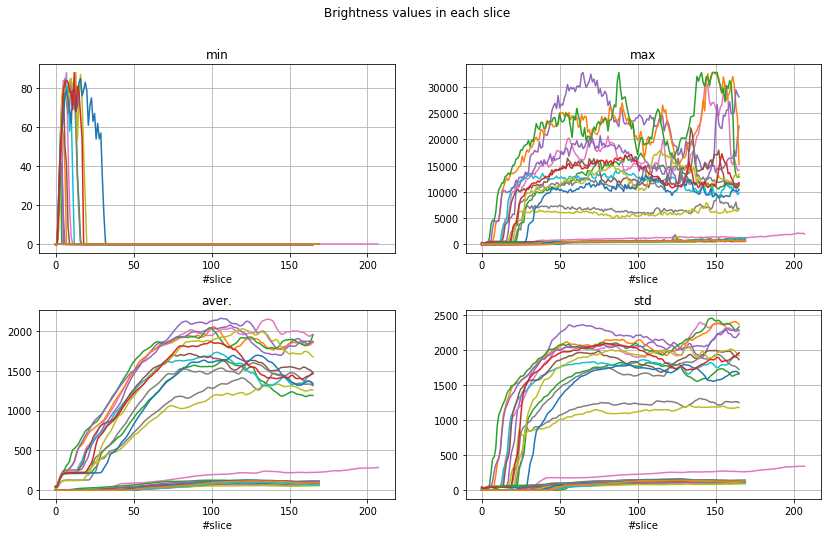

In [13]:
# plot of all slice statistisc from a STATSL folder
#%matplotlib qt
%matplotlib inline
os.chdir(statslPth)
pthInfo()

sl_files = os.listdir('.')
sl_files.sort()

f, ax = plt.subplots(2,2, figsize=(14,8))
plt.suptitle('Brightness values in each slice')
plt.subplots_adjust(hspace=0.3)

for k, f in enumerate(sl_files):
    statSL = np.load(f)
    
    mn = statSL[:,0]
    mx = statSL[:,1]
    av = statSL[:,2]
    st = statSL[:,3]
    
    ax[0,0].plot(mn)
    ax[0,0].axes.grid(True)
    ax[0,0].set_title('min')   
    ax[0,0].set_xlabel('#slice')
    
    ax[0,1].plot(mx)
    ax[0,1].axes.grid(True)
    ax[0,1].set_title('max')   
    ax[0,1].set_xlabel('#slice')
   
    ax[1,0].plot(av)
    ax[1,0].axes.grid(True)
    ax[1,0].set_title('aver.') 
    ax[1,0].set_xlabel('#slice')
    
    ax[1,1].plot(st)
    ax[1,1].axes.grid(True)
    ax[1,1].set_title('std')
    ax[1,1].set_xlabel('#slice')

#### Scatter plots for 3D image statisitcs

Current folder is:
	/media/mk/p1ext4/no19/adni/ADNI_from_Alexander/DownloadedNIfTI/STATIM3D


Text(0.5, 0, '#subject')

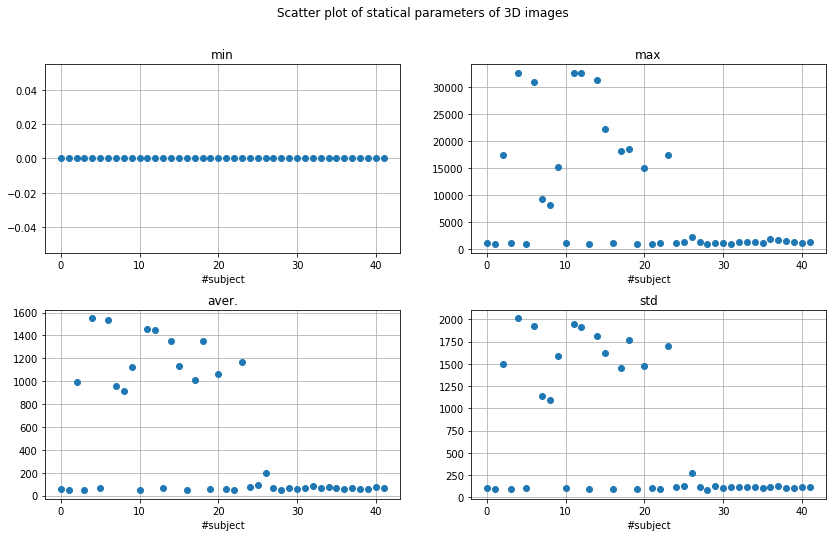

In [14]:
os.chdir(statim3dPth)
pthInfo()

d3_files = os.listdir('.')
d3_files.sort()

stat_all = np.zeros((len(d3_files),4), dtype=np.float32)

for k,f in enumerate(d3_files):
    stat = np.load(f)
    stat_all[k]= stat
       
    
f, ax = plt.subplots(2,2, figsize=(14,8))
plt.suptitle('Scatter plot of statical parameters of 3D images')
plt.subplots_adjust(hspace=0.3)

ax[0,0].plot(stat_all[:,0], 'o')
ax[0,0].axes.grid(True)
ax[0,0].set_title('min')   
ax[0,0].set_xlabel('#subject')

ax[0,1].plot(stat_all[:,1], 'o')
ax[0,1].axes.grid(True)
ax[0,1].set_title('max')   
ax[0,1].set_xlabel('#subject')

ax[1,0].plot(stat_all[:,2], 'o')
ax[1,0].axes.grid(True)
ax[1,0].set_title('aver.')
ax[1,0].set_xlabel('#subject')

ax[1,1].plot(stat_all[:,3], 'o')
ax[1,1].axes.grid(True)
ax[1,1].set_title('std')
ax[1,1].set_xlabel('#subject')

#### 3D scatter plot 

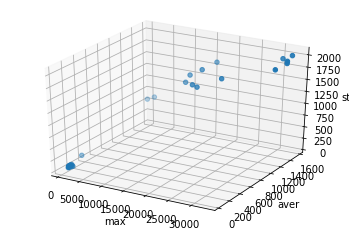

In [15]:
if 0: 
    %matplotlib qt5    
else:
    %matplotlib inline
    
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = stat_all[:,1]
ys = stat_all[:,2]
zs = stat_all[:,3]
ax.scatter(xs, ys, zs)
ax.set_xlabel('max')
ax.set_ylabel('aver')
ax.set_zlabel('std')

plt.show()

---

#### Visualization

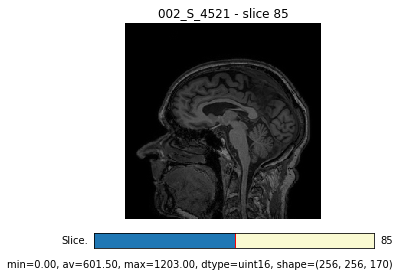

In [16]:
# display numpy image
if 0: 
    %matplotlib qt5    
else:
    %matplotlib inline
import mkViewer2A as mkv
tracker = mkv.IndexTracker(im3dd, 'gray', title=sub, rot=False)